# **IMPORT LIBRARY**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Input
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate
from google.colab import files

# **DOWNLOAD DATASET dan LOAD DATASET**

In [ ]:
# Download file ZIP dari UCI dan simpan sebagai dresses.zip
!wget https://archive.ics.uci.edu/static/public/289/dresses+attribute+sales.zip -O dresses.zip

# Ekstrak ZIP → hasilnya file RAR
!unzip dresses.zip -d dresses_data

# Install unrar (kalau belum ada)
!apt-get install unrar -y

# Ekstrak file RAR → hasilnya file Excel/CSV
!unrar x dresses_data/Dresses_Attribute_Sales.rar dresses_data/

--2025-12-15 03:33:21--  https://archive.ics.uci.edu/static/public/289/dresses+attribute+sales.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘dresses.zip’

dresses.zip             [  <=>               ]   5.56M  13.9MB/s    in 0.4s    

2025-12-15 03:33:22 (13.9 MB/s) - ‘dresses.zip’ saved [5832376]

Archive:  dresses.zip
replace dresses_data/Dresses_Attribute_Sales.rar? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
 extracting: dresses_data/Dresses_Attribute_Sales.rar  
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from dresses_data/Dresses_Att

In [ ]:
# LOAD DATASET

# Load file atribut
df_attr = pd.read_excel("/content/dresses_data/Dresses_Attribute_Sales/Attribute DataSet.xlsx")

# Load file sales
df_sales = pd.read_excel("/content/dresses_data/Dresses_Attribute_Sales/Extra files/Dress Sales.xlsx")

In [ ]:
# Gabungkan dataset berdasarkan Dress_ID
df = pd.merge(df_attr, df_sales, on="Dress_ID", how="inner")

# **EXPLORATORY DATA ANALYSIS (EDA)**

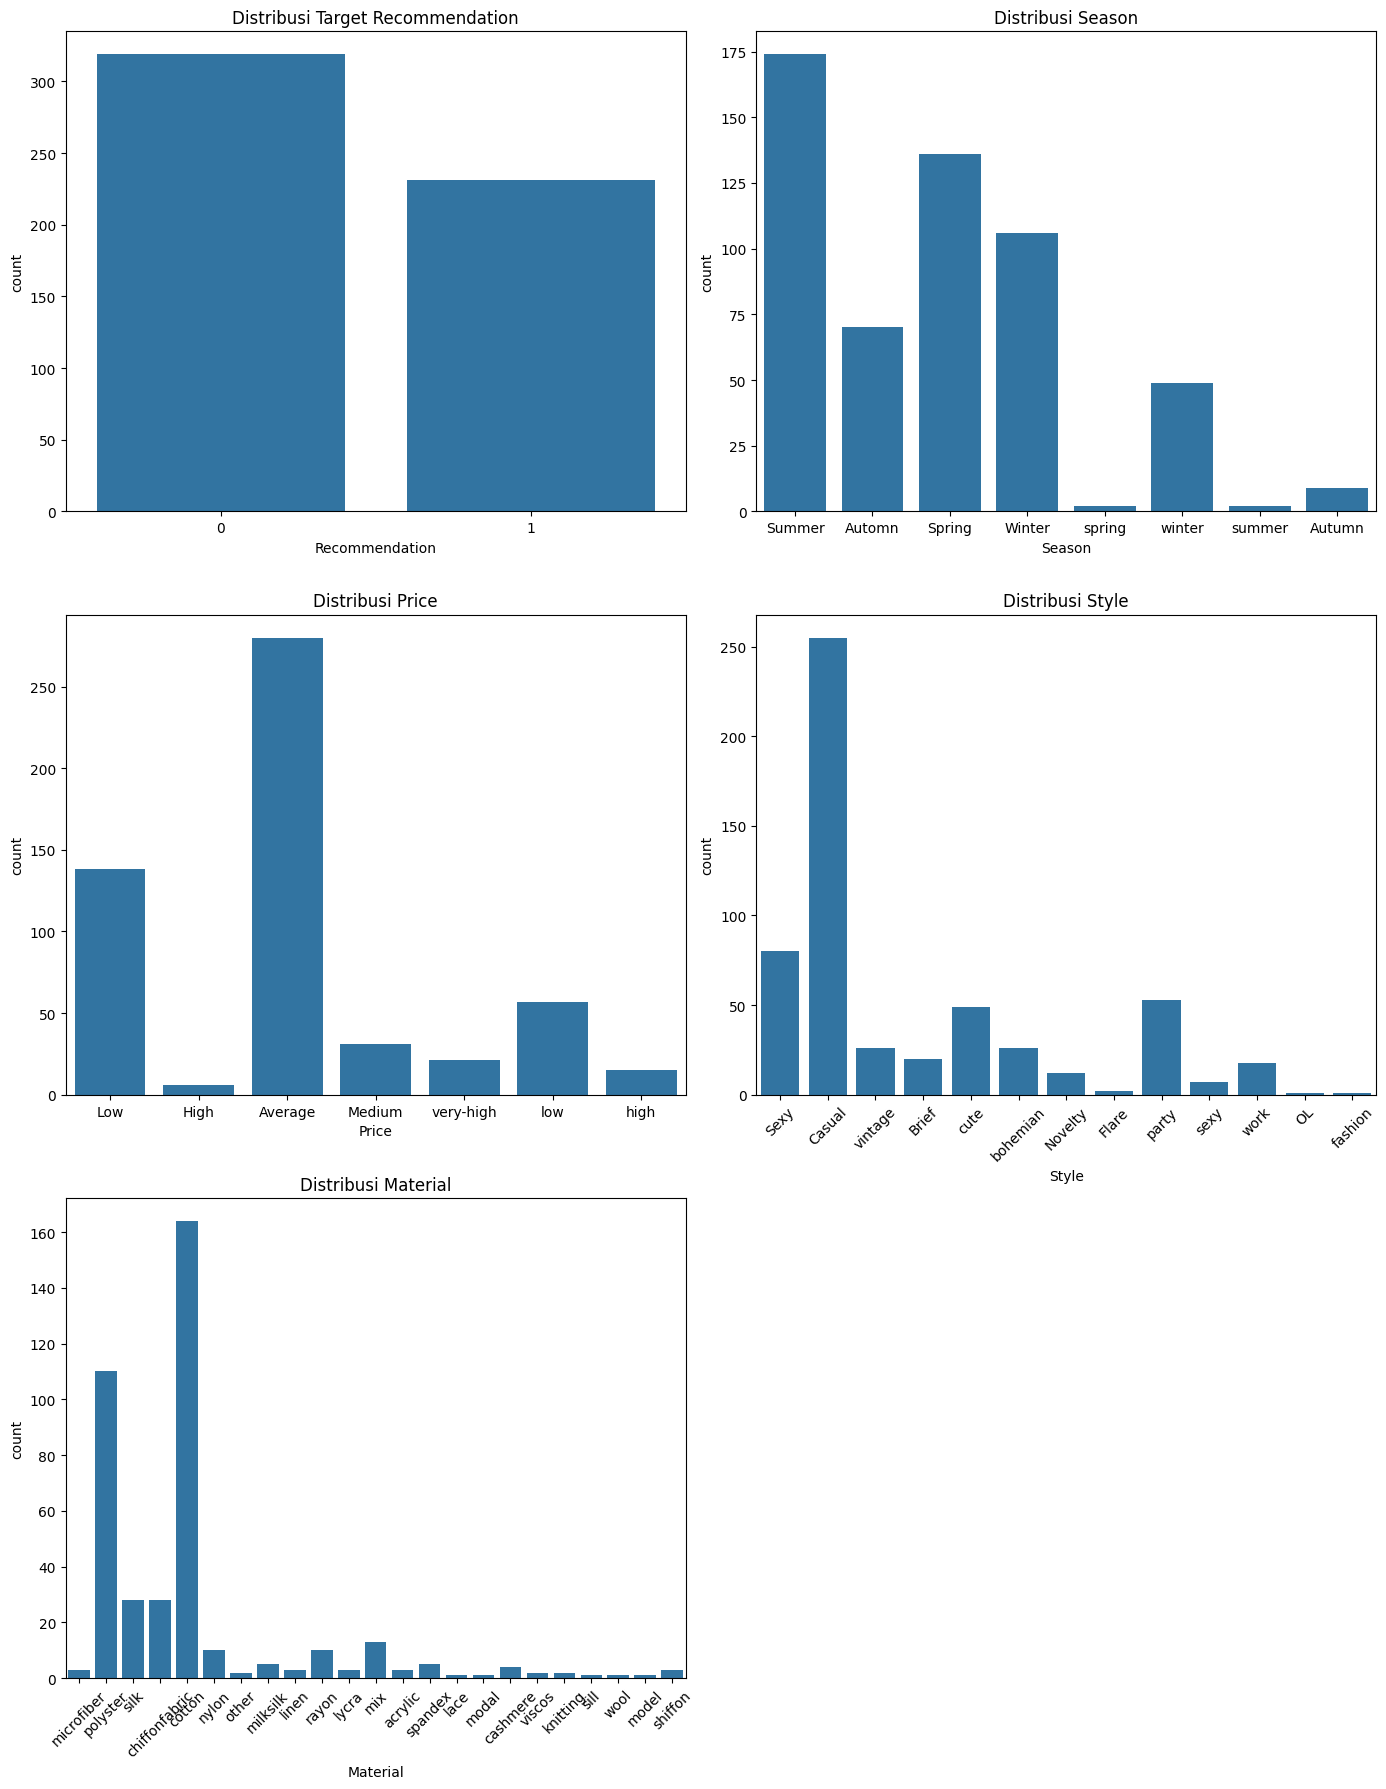

In [ ]:
# Univariate Analysis (Distribusi Setiap Fitur)
plt.figure(figsize=(14, 18))

# Distribusi Target Recommendation
plt.subplot(3, 2, 1)
sns.countplot(x="Recommendation", data=df)
plt.title("Distribusi Target Recommendation")

# Distribusi Season
plt.subplot(3, 2, 2)
sns.countplot(x="Season", data=df)
plt.title("Distribusi Season")

# Distribusi Price
plt.subplot(3, 2, 3)
sns.countplot(x="Price", data=df)
plt.title("Distribusi Price")

# Distribusi Style
plt.subplot(3, 2, 4)
sns.countplot(x="Style", data=df)
plt.title("Distribusi Style")
plt.xticks(rotation=45)

# Distribusi Material
plt.subplot(3, 2, 5)
sns.countplot(x="Material", data=df)
plt.title("Distribusi Material")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

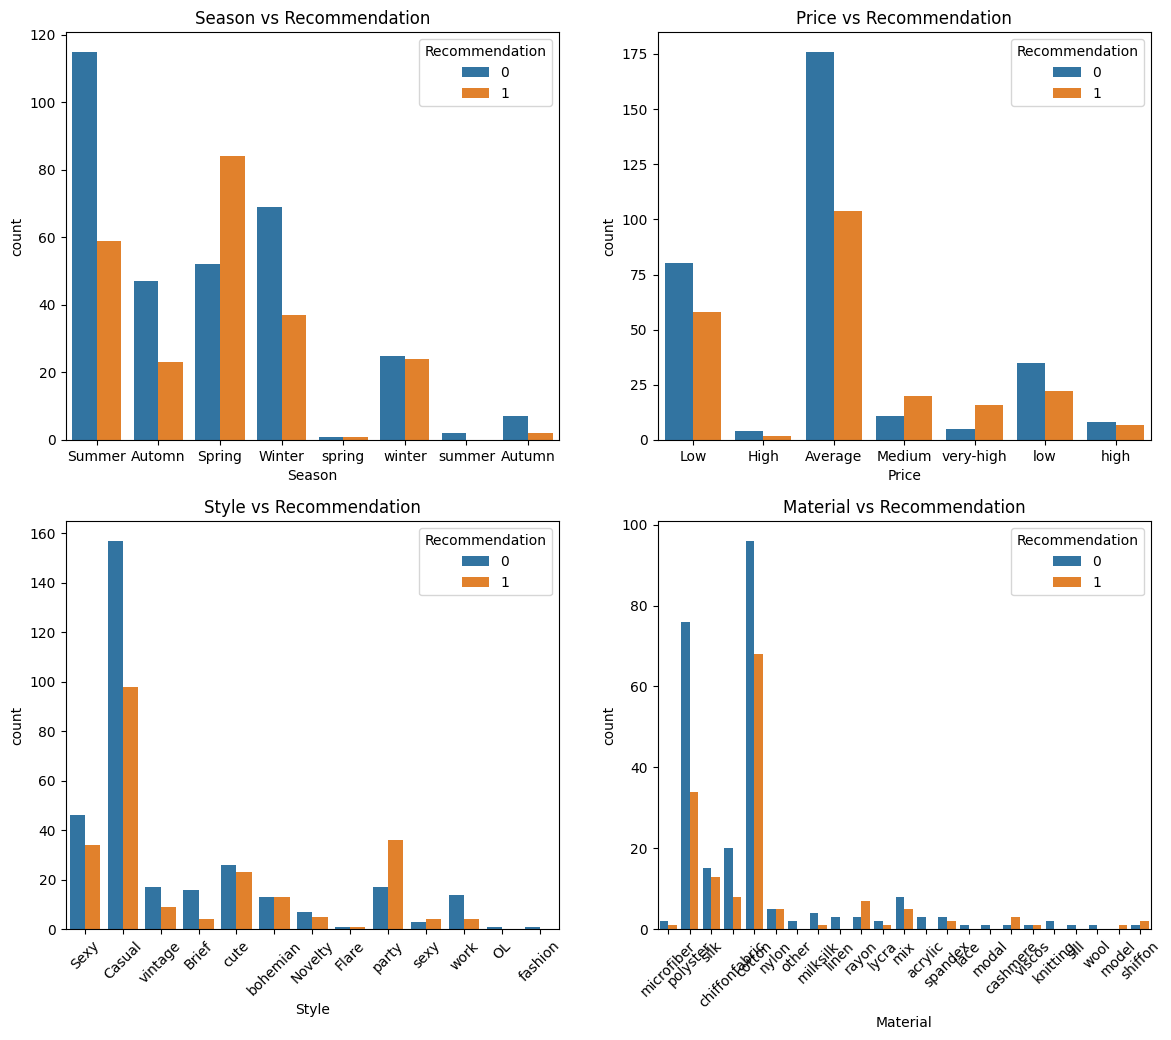

In [ ]:
# Bivariate Analysis (Hubungan Fitur dengan Target)
plt.figure(figsize=(14, 18))  # ukuran besar agar tidak dempet

# Season vs Recommendation
plt.subplot(3, 2, 1)
sns.countplot(x="Season", hue="Recommendation", data=df)
plt.title("Season vs Recommendation")

# Price vs Recommendation
plt.subplot(3, 2, 2)
sns.countplot(x="Price", hue="Recommendation", data=df)
plt.title("Price vs Recommendation")

# Style vs Recommendation
plt.subplot(3, 2, 3)
sns.countplot(x="Style", hue="Recommendation", data=df)
plt.title("Style vs Recommendation")
plt.xticks(rotation=45);

# Material vs Recommendation
plt.subplot(3, 2, 4)
sns.countplot(x="Material", hue="Recommendation", data=df)
plt.title("Material vs Recommendation")
plt.xticks(rotation=45);

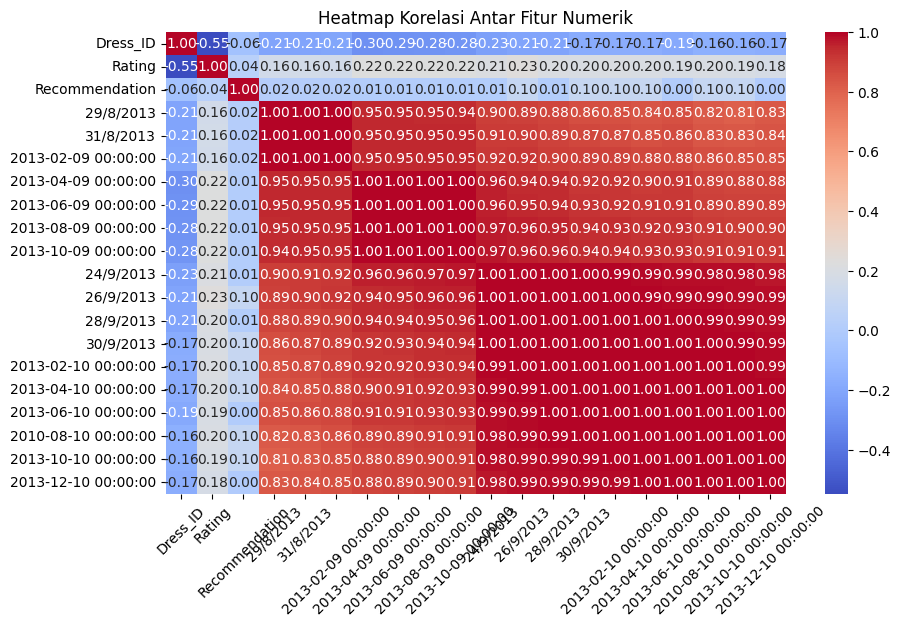

In [ ]:
df_corr = df.select_dtypes(include='number')

plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

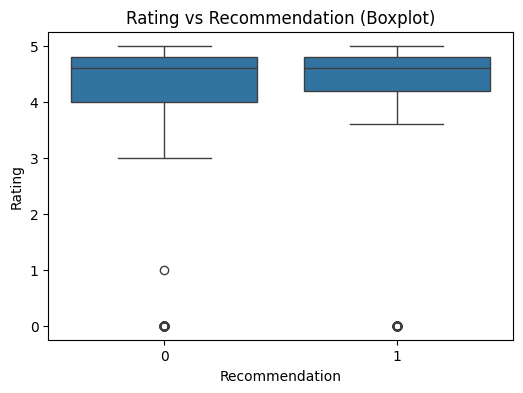

In [ ]:
# BOXPLOT FITUR NUMERIK vs TARGET
plt.figure(figsize=(6,4))
sns.boxplot(x="Recommendation", y="Rating", data=df)
plt.title("Rating vs Recommendation (Boxplot)")
plt.show()

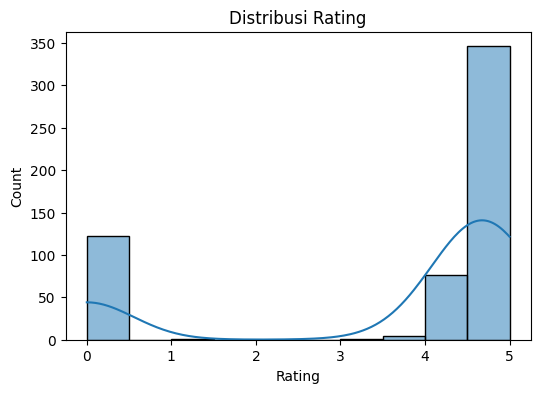

In [ ]:
# DISTRIBUSI FITUR NUMERIK
if "Sales" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df["Sales"], bins=10, kde=True)
    plt.title("Distribusi Sales")
    plt.show()
else:
    plt.figure(figsize=(6,4))
    sns.histplot(df["Rating"], bins=10, kde=True)
    plt.title("Distribusi Rating")
    plt.show()


# **DATA CLEANING**

In [ ]:
# CEK SEMUA KOLOM YANG ADA
print("Daftar kolom asli:")
df_raw = df.copy()
print(df_raw.columns.tolist())

Daftar kolom asli:
['Dress_ID', 'Style', 'Price', 'Rating', 'Size', 'Season', 'NeckLine', 'SleeveLength', 'waiseline', 'Material', 'FabricType', 'Decoration', 'Pattern Type', 'Recommendation', '29/8/2013', '31/8/2013', datetime.datetime(2013, 2, 9, 0, 0), datetime.datetime(2013, 4, 9, 0, 0), datetime.datetime(2013, 6, 9, 0, 0), datetime.datetime(2013, 8, 9, 0, 0), datetime.datetime(2013, 10, 9, 0, 0), datetime.datetime(2013, 12, 9, 0, 0), '14/9/2013', '16/9/2013', '18/9/2013', '20/9/2013', '22/9/2013', '24/9/2013', '26/9/2013', '28/9/2013', '30/9/2013', datetime.datetime(2013, 2, 10, 0, 0), datetime.datetime(2013, 4, 10, 0, 0), datetime.datetime(2013, 6, 10, 0, 0), datetime.datetime(2010, 8, 10, 0, 0), datetime.datetime(2013, 10, 10, 0, 0), datetime.datetime(2013, 12, 10, 0, 0)]


In [ ]:
#cek tipedata
df.dtypes

,0
Dress_ID,int64
Style,object
Price,object
Rating,float64
Size,object
Season,object
NeckLine,object
SleeveLength,object
waiseline,object
Material,object


In [ ]:
print(df.head())

     Dress_ID    Style    Price  Rating Size  Season NeckLine SleeveLength  \
0  1006032852     Sexy      Low     4.6    M  Summer   o-neck    sleevless   
1  1212192089   Casual      Low     0.0    L  Summer   o-neck        Petal   
2  1190380701  vintage     High     0.0    L  Automn   o-neck         full   
3   966005983    Brief  Average     4.6    L  Spring   o-neck         full   
4   876339541     cute      Low     4.5    M  Summer   o-neck    butterfly   

  waiseline       Material  ... 24/9/2013 26/9/2013 28/9/2013  30/9/2013  \
0    empire            NaN  ...      3554    3624.0      3706     3746.0   
1   natural     microfiber  ...      2710    2942.0      3258     3354.0   
2   natural       polyster  ...        11      11.0        11       11.0   
3   natural           silk  ...      1878    1892.0      1914     1924.0   
4   natural  chiffonfabric  ...      2032    2156.0      2252     2312.0   

   2013-02-10 00:00:00  2013-04-10 00:00:00  2013-06-10 00:00:00  \
0     

In [ ]:
# DAFTAR FITUR ATRIBUT YANG RELEVAN UNTUK MODELING
fitur_atribut = [
    'Style', 'Price', 'Rating', 'Size', 'Season',
    'NeckLine', 'SleeveLength', 'Material',
    'FabricType', 'Decoration', 'Recommendation'
]

In [ ]:
# FILTER HANYA KOLOM YANG BENAR-BENAR ADA DI DATASET
fitur_valid = [col for col in fitur_atribut if col in df_raw.columns]

print("\nKolom atribut yang ditemukan:")
print(fitur_valid)


Kolom atribut yang ditemukan:
['Style', 'Price', 'Rating', 'Size', 'Season', 'NeckLine', 'SleeveLength', 'Material', 'FabricType', 'Decoration', 'Recommendation']


In [ ]:
# MEMBUAT DATASET ATRIBUT SAJA
# (menghapus kolom tanggal, Dress_ID, pivot penjualan, dll)
df_clean = df_raw[fitur_valid].copy()

print("\nDataset atribut berhasil dibuat!")
print("Ukuran dataset:", df_clean.shape)
print("Kolom:", df_clean.columns.tolist())


Dataset atribut berhasil dibuat!
Ukuran dataset: (550, 11)
Kolom: ['Style', 'Price', 'Rating', 'Size', 'Season', 'NeckLine', 'SleeveLength', 'Material', 'FabricType', 'Decoration', 'Recommendation']


In [ ]:
# CEK MISSING VALUE SEBELUM CLEANING
print("MISSING VALUE SEBELUM CLEANING")
print(df_raw.isnull().sum())
print("\nTotal missing value:", df_raw.isnull().sum().sum())


MISSING VALUE SEBELUM CLEANING
Dress_ID                 0
Style                    0
Price                    2
Rating                   0
Size                     0
Season                   2
NeckLine                 3
SleeveLength             2
waiseline               92
Material               147
FabricType             292
Decoration             266
Pattern Type           119
Recommendation           0
29/8/2013                0
31/8/2013                0
2013-02-09 00:00:00      0
2013-04-09 00:00:00      0
2013-06-09 00:00:00      0
2013-08-09 00:00:00      0
2013-10-09 00:00:00      0
2013-12-09 00:00:00      0
14/9/2013                0
16/9/2013                0
18/9/2013                0
20/9/2013                0
22/9/2013                0
24/9/2013                0
26/9/2013              273
28/9/2013                0
30/9/2013              312
2013-02-10 00:00:00    315
2013-04-10 00:00:00    314
2013-06-10 00:00:00      0
2010-08-10 00:00:00    311
2013-10-10 00:00:00    3

In [ ]:
# TANGANI MISSING VALUE
df_clean = df_clean.dropna()

print("\nSetelah menangani missing value:")
print(df_clean.isnull().sum())



Setelah menangani missing value:
Style             0
Price             0
Rating            0
Size              0
Season            0
NeckLine          0
SleeveLength      0
Material          0
FabricType        0
Decoration        0
Recommendation    0
dtype: int64


In [ ]:
# Cek duplikasi
print("Jumlah duplikasi:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplikasi setelah dibersihkan:", df.duplicated().sum())

Jumlah duplikasi: 0
Duplikasi setelah dibersihkan: 0


In [ ]:
# Cek outlier (IQR) untuk kolom numerik
# Ambil kolom numerik
kolom_numerik = df_clean.select_dtypes(include=['int64', 'float64']).columns
print("Kolom numerik:", kolom_numerik.tolist())
for kolom in kolom_numerik:
    Q1 = df_clean[kolom].quantile(0.25)
    Q3 = df_clean[kolom].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = df_clean[(df_clean[kolom] < lower) | (df_clean[kolom] > upper)].shape[0]
    print(f"\nOutlier pada kolom {kolom}: {outlier_count} baris")

Kolom numerik: ['Rating', 'Recommendation']

Outlier pada kolom Rating: 0 baris

Outlier pada kolom Recommendation: 0 baris


In [ ]:
# Cek imbalance target
print("CEK IMBALANCE TARGET")
print(df_clean['Recommendation'].value_counts())
print("\nPersentase:")
print(df_clean['Recommendation'].value_counts(normalize=True) * 100)

CEK IMBALANCE TARGET
Recommendation
0    73
1    56
Name: count, dtype: int64

Persentase:
Recommendation
0    56.589147
1    43.410853
Name: proportion, dtype: float64


In [ ]:
# Cek noise (nilai aneh)
for kolom in df_clean.select_dtypes(include=['object']).columns:
    print(f"Nilai unik kolom {kolom}")
    print(df_clean[kolom].unique())

Nilai unik kolom Style
['Brief' 'cute' 'Novelty' 'Flare' 'party' 'Casual' 'sexy' 'Sexy' 'work'
 'vintage' 'bohemian']
Nilai unik kolom Price
['Average' 'Low' 'Medium' 'High' 'low' 'very-high' 'high']
Nilai unik kolom Size
['L' 'M' 'free' 'XL' 'S']
Nilai unik kolom Season
['Spring' 'Summer' 'Automn' 'Winter' 'winter' 'Autumn']
Nilai unik kolom NeckLine
['o-neck' 'v-neck' 'boat-neck' 'ruffled' 'open' 'peterpan-collor'
 'slash-neck' 'Sweetheart' 'Scoop' 'sqare-collor' 'backless' 'bowneck'
 'turndowncollor']
Nilai unik kolom SleeveLength
['full' 'butterfly' 'short' 'sleevless' 'halfsleeve' 'threequarter'
 'threequater' 'sleeveless' 'thressqatar']
Nilai unik kolom Material
['silk' 'chiffonfabric' 'polyster' 'cotton' 'other' 'linen' 'rayon'
 'lycra' 'mix' 'spandex' 'microfiber' 'viscos' 'nylon' 'model' 'shiffon']
Nilai unik kolom FabricType
['chiffon' 'broadcloth' 'other' 'satin' 'worsted' 'jersey' 'woolen'
 'poplin' 'tulle' 'sattin' 'organza' 'lace' 'wollen' 'shiffon' 'terry'
 'Corduroy']
N

In [ ]:
# Normalisasi
scaler = MinMaxScaler()
df_clean['Rating_norm'] = scaler.fit_transform(df_clean[['Rating']])
print("\nRating setelah normalisasi:")
print(df_clean[['Rating', 'Rating_norm']].head())


Rating setelah normalisasi:
   Rating  Rating_norm
3     4.6         0.92
4     4.5         0.90
7     0.0         0.00
8     0.0         0.00
9     0.0         0.00


In [ ]:
# HASIL AKHIR DATA CLEANING
print("DATA CLEANING SELESAI")
print("Ukuran final dataset:", df_clean.shape)

DATA CLEANING SELESAI
Ukuran final dataset: (129, 12)


# **FEATURE ENGINEERING**

In [ ]:
# 1. CREATING NEW FEATURES
print("1. CREATING NEW FEATURES")

# Initialize df_fe from df_clean
df_fe = df_clean.copy()

# Membuat fitur baru: Rating Category
# Kategorisasi Rating menjadi Low, Medium, High
def categorize_rating(rating):
    if rating < 3.5:
        return 'Low'
    elif rating < 4.5:
        return 'Medium'
    else:
        return 'High'

df_fe['Rating_Category'] = df_fe['Rating'].apply(categorize_rating)
print("Fitur baru 'Rating_Category' berhasil dibuat")
print(f"  Kategori: {df_fe['Rating_Category'].unique()}")

# Membuat fitur baru: Price Level (kombinasi Price dengan informasi lain)
df_fe['Price_Season'] = df_fe['Price'].astype(str) + '_' + df_fe['Season'].astype(str)
print("Fitur baru 'Price_Season' berhasil dibuat")
print(f"  Jumlah kombinasi: {df_fe['Price_Season'].nunique()}")

print(f"Total fitur setelah creating: {df_fe.shape[1]} kolom")

# 2. FEATURE EXTRACTION
print("\n2. FEATURE EXTRACTION")

# Perbaiki nama kolom yang salah ejaan
print("Memperbaiki nama kolom yang typo...")
df_fe.rename(columns={
    "waiseline": "WaistLine",
    "Pattern Type": "PatternType"
}, inplace=True)
print("  - 'waiseline' → 'WaistLine'")
print("  - 'Pattern Type' → 'PatternType'")

# Standarisasi kapitalisasi kategori
print("Standarisasi kapitalisasi pada fitur kategorikal...")
categorical_cols = [
    "Style", "Price", "Size", "Season", "NeckLine",
    "SleeveLength", "WaistLine", "Material",
    "FabricType", "Decoration", "PatternType"
]

for col in categorical_cols:
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].astype(str).str.strip().str.title()

print(f"  - {len(categorical_cols)} kolom kategorikal telah distandarisasi")

# Pastikan Rating numerik
print("Konversi Rating ke tipe numerik...")
df_fe["Rating"] = pd.to_numeric(df_fe["Rating"], errors="coerce")
print(f"Tipe data Rating: {df_fe['Rating'].dtype}")

print(f"Total fitur setelah extraction: {df_fe.shape[1]} kolom")

# 3. DIMENSIONALITY REDUCTION
print("\n3. DIMENSIONALITY REDUCTION")

# DROP KOLOM TANGGAL yang tidak relevan
print("Menghapus kolom tanggal yang tidak relevan...")
date_cols = [
    col for col in df_fe.columns if isinstance(col, str) and "/" in col
] + [
    col for col in df_fe.columns if not isinstance(col, str)
]

df_clean = df_fe.drop(columns=date_cols)
print(f"  - Jumlah kolom tanggal dihapus: {len(date_cols)}")

# Filter hanya kolom atribut yang relevan
print("Filter kolom atribut yang relevan untuk modeling...")
fitur_atribut = [
    'Style', 'Price', 'Rating', 'Size', 'Season',
    'NeckLine', 'SleeveLength', 'WaistLine', 'Material',
    'FabricType', 'Decoration', 'PatternType', 'Recommendation',
    'Rating_Category', 'Price_Season'  # Fitur baru
]

fitur_valid = [col for col in fitur_atribut if col in df_clean.columns]
df_clean = df_clean[fitur_valid].copy()

print(f"Jumlah fitur yang dipertahankan: {len(fitur_valid)}")
print(f"Total fitur setelah reduction: {df_clean.shape[1]} kolom")

# 4. FEATURE SELECTION (akan dilakukan setelah encoding)
print("\n4. FEATURE SELECTION")
print("Feature Selection akan dilakukan setelah One-Hot Encoding")
print("  - Metode: SelectKBest dengan Chi-Square")
print("  - Target: Pilih 50 fitur terbaik")

# RINGKASAN FEATURE ENGINEERING
print("FEATURE ENGINEERING SELESAI")
print(f"Ukuran dataset akhir: {df_clean.shape}")
print(f"Jumlah fitur: {df_clean.shape[1]} kolom")
print(f"Jumlah baris: {df_clean.shape[0]} baris")
print("\nKolom yang tersedia:")
for i, col in enumerate(df_clean.columns, 1):
    print(f"  {i}. {col}")

# Tampilkan 5 baris pertama
print("\n5 Baris Pertama Dataset:")
print(df_clean.head())

1. CREATING NEW FEATURES
Fitur baru 'Rating_Category' berhasil dibuat
  Kategori: ['High' 'Low' 'Medium']
Fitur baru 'Price_Season' berhasil dibuat
  Jumlah kombinasi: 22
Total fitur setelah creating: 14 kolom

2. FEATURE EXTRACTION
Memperbaiki nama kolom yang typo...
  - 'waiseline' → 'WaistLine'
  - 'Pattern Type' → 'PatternType'
Standarisasi kapitalisasi pada fitur kategorikal...
  - 11 kolom kategorikal telah distandarisasi
Konversi Rating ke tipe numerik...
Tipe data Rating: float64
Total fitur setelah extraction: 14 kolom

3. DIMENSIONALITY REDUCTION
Menghapus kolom tanggal yang tidak relevan...
  - Jumlah kolom tanggal dihapus: 0
Filter kolom atribut yang relevan untuk modeling...
Jumlah fitur yang dipertahankan: 13
Total fitur setelah reduction: 13 kolom

4. FEATURE SELECTION
Feature Selection akan dilakukan setelah One-Hot Encoding
  - Metode: SelectKBest dengan Chi-Square
  - Target: Pilih 50 fitur terbaik
FEATURE ENGINEERING SELESAI
Ukuran dataset akhir: (129, 13)
Jumlah fit

# **DATA TRANSFORMATION**

In [ ]:
# DROP KOLOM TANGGAL
date_cols = [
    col for col in df_fe.columns if isinstance(col, str) and "/" in col
] + [
    col for col in df_fe.columns if not isinstance(col, str) and not isinstance(col, pd.Timestamp)
]

df_clean = df_fe.drop(columns=date_cols, errors='ignore')

print("Kolom tanggal dihapus:", len(date_cols))

# Normalisasi Rating dan penambahan Rating_norm
scaler = MinMaxScaler()
df_clean['Rating_norm'] = scaler.fit_transform(df_clean[['Rating']])

print("\nRating setelah normalisasi:")
print(df_clean[['Rating', 'Rating_norm']].head())

#  Handle original Rating column
if 'Rating' in df_clean.columns and 'Rating_norm' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Rating'])
    print("\nDropped original 'Rating' column from df_clean as 'Rating_norm' is available and will be used.")

# --- DATA SPLITTING ---
# X = semua fitur kecuali target
X = df_clean.drop("Recommendation", axis=1)
# y = target / label
y = df_clean["Recommendation"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nData Splitting selesai.")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)
# --- END DATA SPLITTING ---


# IDENTIFIKASI FITUR UNTUK PREPROCESSOR
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("\nKolom numerikal yang dipakai untuk pipeline:", numerical_cols)
print("Kolom kategorikal yang dipakai untuk pipeline:", categorical_cols)

# PIPELINE NUMERIK
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# PIPELINE KATEGORIKAL
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# GABUNGKAN PIPELINE
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# TRANSFORMASI
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nData Transformation selesai.")
print("Jumlah fitur setelah OHE:", X_train_processed.shape[1])

Kolom tanggal dihapus: 0

Rating setelah normalisasi:
   Rating  Rating_norm
3     4.6         0.92
4     4.5         0.90
7     0.0         0.00
8     0.0         0.00
9     0.0         0.00

Dropped original 'Rating' column from df_clean as 'Rating_norm' is available and will be used.

Data Splitting selesai.
X_train: (103, 12)
X_test : (26, 12)
y_train: (103,)
y_test : (26,)

Kolom numerikal yang dipakai untuk pipeline: ['Rating_norm']
Kolom kategorikal yang dipakai untuk pipeline: ['Style', 'Price', 'Size', 'Season', 'NeckLine', 'SleeveLength', 'Material', 'FabricType', 'Decoration', 'Rating_Category', 'Price_Season']

Data Transformation selesai.
Jumlah fitur setelah OHE: 114


# **DATA SPLITTING**

In [ ]:
X = df_clean.drop("Recommendation", axis=1)
y = df_clean["Recommendation"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data Splitting selesai.")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

Data Splitting selesai.
X_train: (103, 12)
X_test : (26, 12)
y_train: (103,)
y_test : (26,)


# **FEATURE SELECTION**

In [ ]:
selector = SelectKBest(score_func=chi2, k=50)

X_train_fs = selector.fit_transform(X_train_processed, y_train)
X_test_fs = selector.transform(X_test_processed)

print("Feature Selection selesai.")
print("Jumlah fitur terpilih:", X_train_fs.shape[1])

Feature Selection selesai.
Jumlah fitur terpilih: 50


# **MODELING**

In [ ]:
# EVALUASI
def evaluate_model(y_true, y_pred, model_name, train_time):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training Time (s): {train_time:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    return acc, prec, rec, f1

In [ ]:
# VISUALISASI MODEL
def show_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


=== Logistic Regression ===
Accuracy: 0.7692
Precision: 0.6667
Recall: 0.9091
F1-Score: 0.7692
Training Time (s): 0.0067

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.67      0.91      0.77        11

    accuracy                           0.77        26
   macro avg       0.79      0.79      0.77        26
weighted avg       0.81      0.77      0.77        26

Confusion Matrix:
[[10  5]
 [ 1 10]]


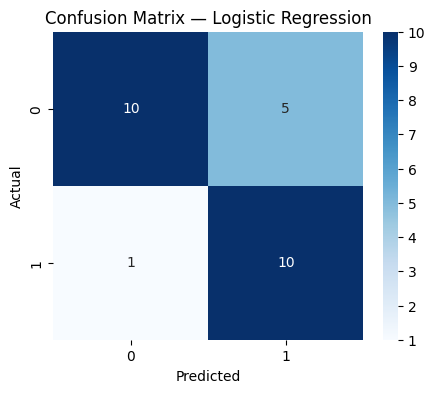

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Logistic Regression
start = time.time()
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_fs, y_train)
time_logreg = time.time() - start

y_pred_logreg = logreg.predict(X_test_fs)
evaluate_model(y_test, y_pred_logreg, "Logistic Regression", time_logreg)
show_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")

# Calculate and store metrics for comparison
acc_logreg = accuracy_score(y_test, y_pred_logreg)
prec_logreg = precision_score(y_test, y_pred_logreg)
rec_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

# Save the trained Logistic Regression model
joblib.dump(logreg, "model_logistic_regression.pkl")

# Download the saved model file
files.download("model_logistic_regression.pkl")


=== Random Forest ===
Accuracy: 0.7308
Precision: 0.6250
Recall: 0.9091
F1-Score: 0.7407
Training Time (s): 1.2262

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.62      0.91      0.74        11

    accuracy                           0.73        26
   macro avg       0.76      0.75      0.73        26
weighted avg       0.78      0.73      0.73        26

Confusion Matrix:
[[ 9  6]
 [ 1 10]]


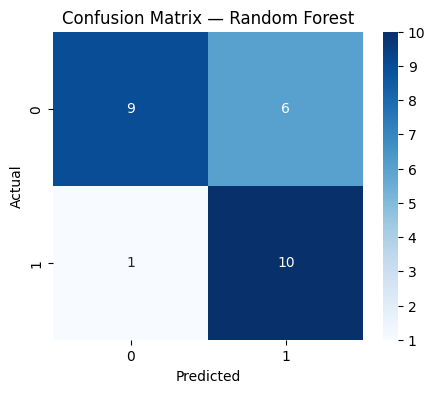

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Random Forest
start = time.time()

rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

rf.fit(X_train_processed, y_train)
time_rf = time.time() - start

# Prediksi
y_pred_rf = rf.predict(X_test_processed)

# Evaluasi
evaluate_model(y_test, y_pred_rf, "Random Forest", time_rf)
show_confusion_matrix(y_test, y_pred_rf, "Random Forest")

# Simpan metrik untuk perbandingan
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Save the trained Random Forest model
joblib.dump(rf, "model_random_forest.pkl")

# Download the saved model file
files.download("model_random_forest.pkl")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.4878 - loss: 0.6941 - val_accuracy: 0.5238 - val_loss: 0.6934
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5110 - loss: 0.6859 - val_accuracy: 0.5714 - val_loss: 0.6830
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5939 - loss: 0.6725 - val_accuracy: 0.5714 - val_loss: 0.6730
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6430 - loss: 0.6464 - val_accuracy: 0.6190 - val_loss: 0.6636
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6596 - loss: 0.6576 - val_accuracy: 0.6190 - val_loss: 0.6552
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6791 - loss: 0.6197 - val_accuracy: 0.6190 - val_loss: 0.6473
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6613 - loss: 0.6156 - val_accuracy: 0.6667 - val_loss: 0.6399
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6891 - loss: 0.6024 - val_accuracy: 0.6667 - val_loss: 0.633

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,549 (174.02 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,700 (116.02 KB)

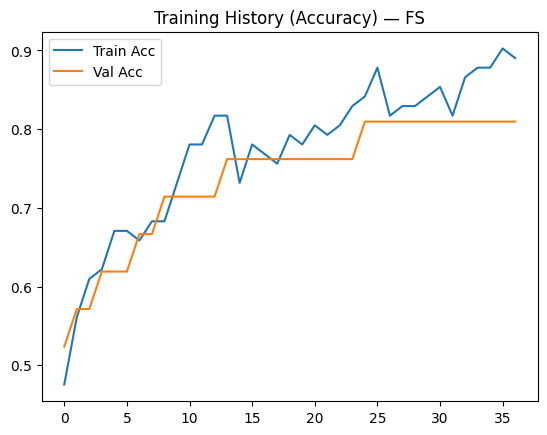

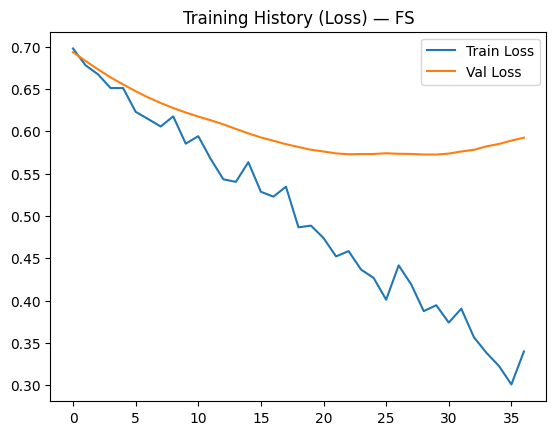

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

=== Deep Learning (MLP) — Feature Selection ===
Accuracy: 0.7692
Precision: 0.6667
Recall: 0.9091
F1-Score: 0.7692
Training Time (s): 10.0829

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.67      0.91      0.77        11

    accuracy                           0.77        26
   macro avg       0.79      0.79      0.77        26
weighted avg       0.81      0.77      0.77        26

Confusion Matrix:
[[10  5]
 [ 1 10]]


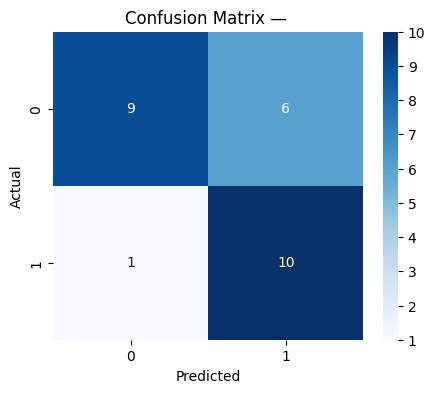

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model MLP
start = time.time()
model_fs = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_fs.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_fs.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history_fs = model_fs.fit(
    X_train_fs, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
train_time_fs = time.time() - start

# Model Summary
print("Model Summary for model_fs")
model_fs.summary()

# Plot Accuracy
plt.plot(history_fs.history['accuracy'], label='Train Acc')
plt.plot(history_fs.history['val_accuracy'], label='Val Acc')
plt.title("Training History (Accuracy) — FS")
plt.legend()
plt.show()

# Plot Loss
plt.plot(history_fs.history['loss'], label='Train Loss')
plt.plot(history_fs.history['val_loss'], label='Val Loss')
plt.title("Training History (Loss) — FS")
plt.legend()
plt.show()

# Evaluasi
y_pred_fs = (model_fs.predict(X_test_fs) > 0.5).astype(int)
evaluate_model(y_test, y_pred_fs, "Deep Learning (MLP) — Feature Selection", train_time_fs)
show_confusion_matrix(y_test, y_pred_rf, "")

# Save the trained Random Forest model
joblib.dump(rf, "model_deep_learning(mlp).pkl")

# Download the saved model file
files.download("model_deep_learning(mlp).pkl")

In [ ]:
# PERBANDINGAN SEMUA MODEL
acc_mlp = accuracy_score(y_test, y_pred_fs)
prec_mlp = precision_score(y_test, y_pred_fs)
rec_mlp = recall_score(y_test, y_pred_fs)
f1_mlp = f1_score(y_test, y_pred_fs)

comparison_data = {
    "Model": [
        "Baseline – Logistic Regression",
        "Advanced – Random Forest",
        "Deep Learning – MLP (Feature Selection)"
    ],
    "Accuracy": [ acc_logreg, acc_rf, acc_mlp ],
    "Precision": [ prec_logreg, prec_rf, prec_mlp ],
    "Recall": [ rec_logreg, rec_rf, rec_mlp ],
    "F1-Score": [ f1_logreg, f1_rf, f1_mlp ],
    "Training Time (s)": [ time_logreg, time_rf, train_time_fs ]
}

df_compare = pd.DataFrame(comparison_data)
print("PERBANDINGAN SEMUA MODEL")
print(tabulate(df_compare, headers='keys', tablefmt='grid', showindex=False))

PERBANDINGAN SEMUA MODEL
+-----------------------------------------+------------+-------------+----------+------------+---------------------+
| Model                                   |   Accuracy |   Precision |   Recall |   F1-Score |   Training Time (s) |
+=========================================+============+=============+==========+============+=====================+
| Baseline – Logistic Regression          |   0.769231 |    0.666667 | 0.909091 |   0.769231 |          0.00668025 |
+-----------------------------------------+------------+-------------+----------+------------+---------------------+
| Advanced – Random Forest                |   0.730769 |    0.625    | 0.909091 |   0.740741 |          1.22624    |
+-----------------------------------------+------------+-------------+----------+------------+---------------------+
| Deep Learning – MLP (Feature Selection) |   0.769231 |    0.666667 | 0.909091 |   0.769231 |         10.0829     |
+--------------------------------------

In [ ]:
# MENAMPILKAN PREDIKSI
# Ambil probabilitas mentah dari model
y_prob_fs = model_fs.predict(X_test_fs).flatten()
y_pred_fs = (y_prob_fs > 0.5).astype(int)

# Buat DataFrame hasil
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_fs,
    'Probability (Class 1)': y_prob_fs.round(4)
})

# Tampilkan 10 baris pertama
print("\nContoh Hasil Prediksi Deep Learning:")
print(results.head(10).to_markdown(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Contoh Hasil Prediksi Deep Learning:
|   Actual |   Predicted |   Probability (Class 1) |
|---------:|------------:|------------------------:|
|        0 |           0 |                  0.2079 |
|        0 |           0 |                  0.304  |
|        1 |           1 |                  0.7342 |
|        1 |           1 |                  0.8617 |
|        0 |           1 |                  0.8074 |
|        1 |           1 |                  0.786  |
|        0 |           1 |                  0.8022 |
|        0 |           0 |                  0.2147 |
|        0 |           0 |                  0.4709 |
|        1 |           1 |                  0.9416 |


# **FEATURE IMPORTANCE**

Length of feature_names_after_preprocessing: 114
Length of selector.get_support() (boolean mask): 114


/tmp/ipython-input-3954696601.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


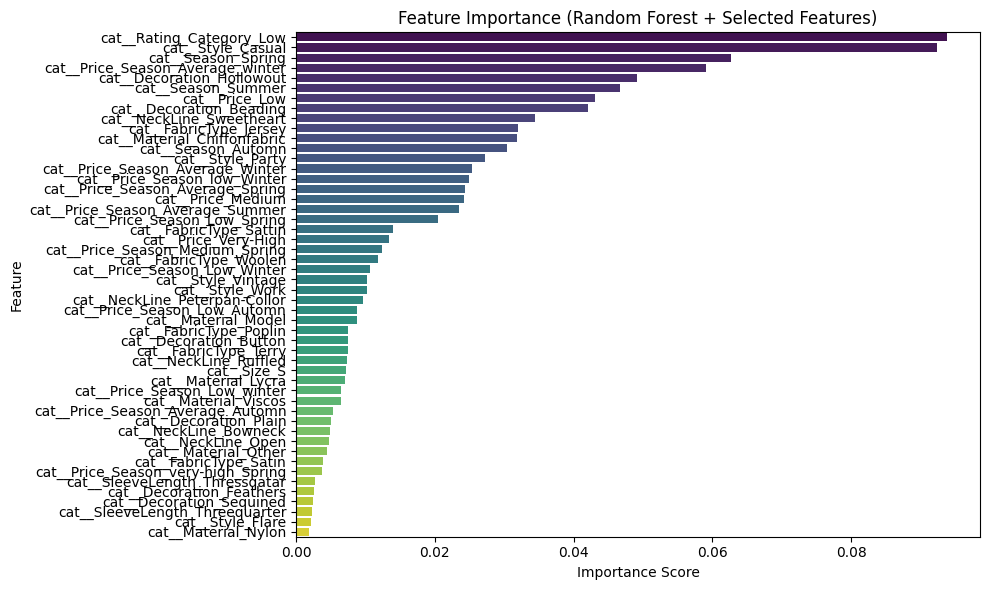

In [ ]:
# Ambil nama fitur setelah ColumnTransformer (ini akan mencakup semua fitur numerik dan OHE)
feature_names_after_preprocessing = preprocessor.get_feature_names_out()

# Debugging: Print lengths to verify consistency
print(f"Length of feature_names_after_preprocessing: {len(feature_names_after_preprocessing)}")
print(f"Length of selector.get_support() (boolean mask): {len(selector.get_support())}")

# FIX: Samakan panjang mask dengan jumlah fitur setelah preprocessing
mask = selector.get_support()[:len(feature_names_after_preprocessing)]

# Ambil nama fitur yang dipilih SelectKBest dari daftar feature_names_after_preprocessing
selected_features = feature_names_after_preprocessing[mask]

# Latih model Random Forest baru pada fitur-fitur yang sudah diseleksi (X_train_fs)
rf_fs = RandomForestClassifier(random_state=42)
rf_fs.fit(X_train_fs, y_train)

# Ambil importance dari model Random Forest yang baru dilatih
feature_importance = rf_fs.feature_importances_

# Buat DataFrame
feat_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp,
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Feature Importance (Random Forest + Selected Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# **MEMISAHKAN FITUR DAN TARGET (LABEL)**

In [ ]:
# X = semua fitur kecuali target
X = df_clean.drop("Recommendation", axis=1)
# y = target / label
y = df_clean["Recommendation"]

print("PEMISAHAN FITUR & TARGET BERHASIL")
print("Ukuran X:", X.shape)
print("Ukuran y:", y.shape)
print("\n5 baris pertama X:")
print(X.head())
print("\n5 baris pertama y:")
print(y.head())

PEMISAHAN FITUR & TARGET BERHASIL
Ukuran X: (129, 12)
Ukuran y: (129,)

5 baris pertama X:
     Style    Price  Size  Season NeckLine SleeveLength       Material  \
3    Brief  Average     L  Spring   O-Neck         Full           Silk   
4     Cute      Low     M  Summer   O-Neck    Butterfly  Chiffonfabric   
7  Novelty  Average  Free  Automn   O-Neck        Short       Polyster   
8  Novelty  Average  Free  Automn   O-Neck        Short       Polyster   
9    Flare  Average  Free  Spring   V-Neck        Short         Cotton   

   FabricType  Decoration  Rating_norm Rating_Category    Price_Season  
3     Chiffon  Embroidary         0.92            High  Average_Spring  
4     Chiffon         Bow         0.90            High      Low_Summer  
7  Broadcloth        Lace         0.00             Low  Average_Automn  
8  Broadcloth        Lace         0.00             Low  Average_Automn  
9  Broadcloth     Beading         0.00             Low  Average_Spring  

5 baris pertama y:
3    1

# **CEK DESKRIPSI DATASET**

In [ ]:
target = "Recommendation"
fitur = X.columns.tolist()   # X = fitur setelah cleaning

print(f"Targetnya    : {target}")
print(f"Nama Fitur   : {fitur}")
print(f"Jumlah Fitur : {len(fitur)} kolom")
print(f"Jumlah baris : {len(df_clean)} baris")
print(f"Ukuran Data  : {df_clean.shape}")

# Cek tipe data
print("\nCek Tipe Data :")
display(df_clean.dtypes)

Targetnya    : Recommendation
Nama Fitur   : ['Style', 'Price', 'Size', 'Season', 'NeckLine', 'SleeveLength', 'Material', 'FabricType', 'Decoration', 'Rating_norm', 'Rating_Category', 'Price_Season']
Jumlah Fitur : 12 kolom
Jumlah baris : 129 baris
Ukuran Data  : (129, 13)

Cek Tipe Data :


,0
Style,object
Price,object
Size,object
Season,object
NeckLine,object
SleeveLength,object
Material,object
FabricType,object
Decoration,object
Recommendation,int64
